<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Привет! Почему проект без названия?</div>

# Анализ программы лояльности интернет магазина

# 0. Введение

Задачи проекта:
- Провести исследовательский анализ данных
- Провести анализ программы лояльности
- Проверить статистические гипотезы о равенстве среднего чека и количнстве товаров

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# 1. Предоработка данных

Загрузим таблицы в проект

In [12]:
orders=pd.read_csv('retail_dataset.csv')
orders.head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
purchaseid         105335 non-null object
item_ID            105335 non-null object
Quantity           105335 non-null int64
purchasedate       105335 non-null object
CustomerID         69125 non-null float64
ShopID             105335 non-null object
loyalty_program    105335 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


Фрейм содержит пропуски и некорректные типы столбцов

Проверим наличие дубликатов

In [14]:
orders.duplicated().value_counts()

False    104302
True       1033
dtype: int64

Избавимся от повторов

In [15]:
orders=orders.drop_duplicates()
orders.duplicated().value_counts()

False    104302
dtype: int64

Приведем столбцы к нужному типу

In [16]:
orders.purchasedate=pd.to_datetime(orders['purchasedate']).dt.date
orders.loyalty_program=orders.loyalty_program.astype('int')
orders.CustomerID=orders.CustomerID.astype('object')
orders=orders.rename(columns={'item_ID':'productID'})

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> На основании чего ты просто взял количество "по модулю" ? Нужно как минимум объяснение. И если бы ыт этого не сделал - работа с некоторыми выбросами ниже была бы проще.</div>

Взглянем на пропуски в столбце CustomerID

In [17]:
orders[orders['CustomerID'].isna()].loyalty_program.value_counts()

0    36148
Name: loyalty_program, dtype: int64

Они согласуются c отсутствием в программе лояльности. Так как, посчитать средний чек для этих клиентов невозможно - избавимся от них

In [18]:
len1=len(orders)

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> А какой процент данных ты сейчас отрезал?</div>

In [19]:
orders=orders.dropna()

In [20]:
round((len1-len(orders))/len1 , 2)

0.35

Потеряли 35% записей в таблице

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Уже лучше.</div>

Взглянем на значения в столбце Quantity

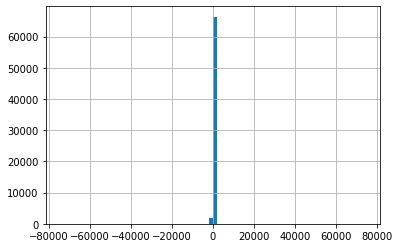

In [21]:
orders.Quantity.hist(bins=80)

Положительные и отрицательные значения расположены симметрично. Скорее всего так в системе отображаются возвраты товара

In [22]:
len2=len(orders)

Оставим только заказы с положительным количеством, так как нулевые и отрицательные значения нельзя расценивать как покупки

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Хорошо, теперь я вижу работу с отрицательынми значениями.</div>

In [23]:
orders=orders.query('Quantity > 0')

In [24]:
round((len2-len(orders))/len2 , 2)

0.21

Потеряли 21% записей в таблице

In [25]:
orders

,purchaseid,productID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10,18427,Shop 0,0
2,538855,21239,7,2016-12-14,22182,Shop 0,1
10,537795,82494L,5,2016-12-08,22892,Shop 0,1
12,543647,21987,3,2017-02-10,18520,Shop 0,0
13,538533,22294,9,2016-12-13,20475,Shop 0,0
...,...,...,...,...,...,...,...
105320,539840,21126,11,2016-12-22,18062,Shop 12,0
105328,537886,22158,7,2016-12-09,21339,Shop 0,0
105332,538068,85048,1,2016-12-09,23657,Shop 0,1
105333,538207,22818,11,2016-12-10,18427,Shop 0,0


---------

In [26]:
products=pd.read_csv('product_codes.csv')
products.head()

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


In [27]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
productID        9969 non-null object
price_per_one    9969 non-null float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


Проверим наличие дубликатов

In [28]:
products.duplicated().value_counts()

False    9969
dtype: int64

In [29]:
products.productID.duplicated().value_counts()

True     6810
False    3159
Name: productID, dtype: int64

Столбец productID содержит дубликаты. Сгруппируем и найдем среднию цену каждого товара

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> В данной ситуации - хорошее решение.</div>

In [30]:
products=products.groupby('productID')['price_per_one'].mean().reset_index()
products

,productID,price_per_one
0,10002,1.380
1,10080,0.850
2,10120,0.210
3,10123C,0.650
4,10124A,0.420
...,...,...
3154,gift_0001_20,16.845
3155,gift_0001_30,25.265
3156,gift_0001_40,34.040
3157,gift_0001_50,42.550


---------

Добавим к таблице orders сумму покупки

In [31]:
retail=orders.merge(products,  on ='productID')
retail['revenue']= retail['Quantity']*retail['price_per_one']
retail=retail.rename(columns={'purchasedate':'date','loyalty_program':'group'})
retail

,purchaseid,productID,Quantity,date,CustomerID,ShopID,group,price_per_one,revenue
0,538280,21873,11,2016-12-10,18427,Shop 0,0,1.810000,19.91
1,541566,21873,35,2017-01-19,23401,Shop 0,1,1.810000,63.35
2,538843,21873,1,2016-12-14,21712,Shop 0,0,1.810000,1.81
3,540838,21873,11,2017-01-11,19541,Shop 0,0,1.810000,19.91
4,543592,21873,5,2017-02-10,22922,Shop 0,1,1.810000,9.05
...,...,...,...,...,...,...,...,...,...
53879,543193,37333,3,2017-02-04,19404,Shop 0,0,5.246667,15.74
53880,542398,85047,1,2017-01-27,18853,Shop 0,0,5.950000,5.95
53881,542617,20731,2,2017-01-30,23142,Shop 0,1,1.250000,2.50
53882,538510,90094,1,2016-12-12,23683,Shop 0,1,2.550000,2.55


# 2. Исследовательский анализ

Сгруппируем строки по номеру заказа и посчитаем стоимость покупок

In [52]:
retail = retail.groupby('purchaseid').agg({
'date' : 'max',
'group' : 'max',
'CustomerID' : 'first',
'revenue' : 'sum',
'Quantity': 'sum'}).reset_index()

In [53]:
retail

,purchaseid,date,group,CustomerID,revenue,Quantity
0,536365,2016-12-01,1,23529.0,184.471417,33
1,536366,2016-12-01,1,23529.0,20.400000,10
2,536367,2016-12-01,0,18726.0,295.588750,71
3,536368,2016-12-01,0,18726.0,84.470000,11
4,536369,2016-12-01,0,18726.0,16.600000,2
...,...,...,...,...,...,...
3323,545190,2017-02-28,0,21335.0,256.804500,74
3324,545191,2017-02-28,0,18490.0,300.686167,90
3325,545213,2017-02-28,1,22197.0,285.600500,113
3326,545214,2017-02-28,1,22844.0,212.104667,90


Создадим список дат за весь период и объединим его с нашиим заказами

In [54]:
dates=pd.DataFrame( {'dates':pd.date_range(start=retail.date.min(), end=retail.date.max()) , '0':1} )
dates['dates']=pd.to_datetime(dates['dates']).dt.date
retail['date']=pd.to_datetime(retail['date']).dt.date
rt=retail.merge(dates, how="outer", left_on='date', right_on='dates')

Взглянем на изменение среднего чека по дням

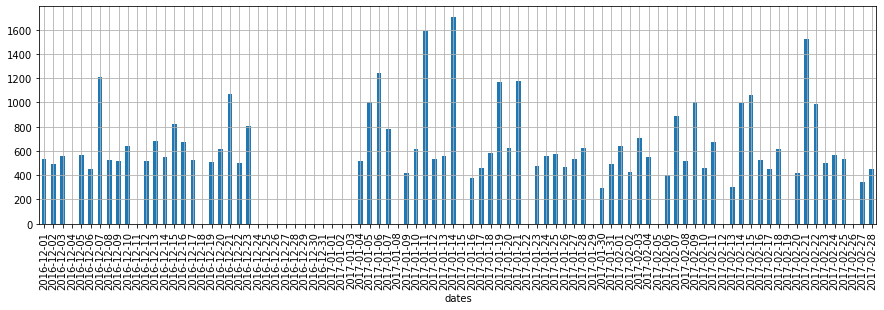

In [55]:
rt.groupby('dates')['revenue'].mean().plot (grid=True, kind='bar', figsize=(15,4))

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Обрати внимание. что ты вообще не видишь тут дат, в которые не было соврешено покупок - а их много. За счет того. что в подписях у тебя именно даты - график не вводит в заблуждение явно, но читать его не легко.</div>

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Теперь отлично.</div>

Взглянем на распределение количества товаров по дням

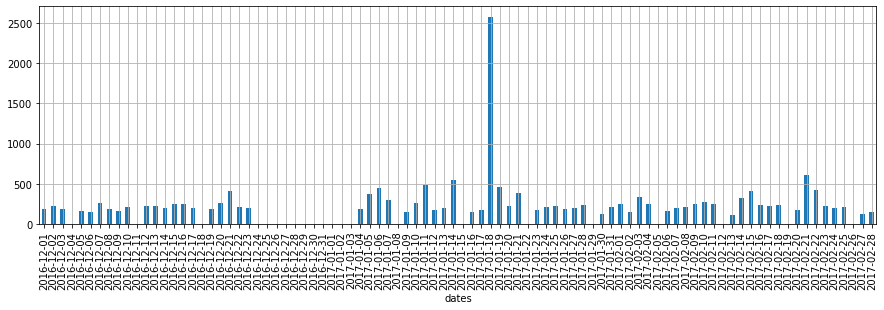

In [37]:
rt.groupby('dates')['Quantity'].mean().plot (grid=True, kind='bar',  figsize=(15,4))

Были дни когда клиенты вообще не совершали покупки

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Имхо - сначала нужно считать все подобные показатели, а потом уже отрезать клиентов без id</div>

2017-01-18 совершено аномально много покупок. Посмотрим на клиентов их сделавших

In [38]:
retail[retail['date'] == pd.to_datetime("2017-01-18")].groupby('CustomerID')['Quantity'].mean().sort_values(ascending=False).head()

CustomerID
18025.0    74214.0
18035.0     1180.0
22101.0     1101.0
20740.0      505.0
20702.0      282.0
Name: Quantity, dtype: float64

Взглянем на покупки пользователя 18025

In [39]:
retail.query('CustomerID == 18025')

,purchaseid,date,group,CustomerID,revenue,Quantity
1880,541431,2017-01-18,0,18025.0,77182.56,74214


Дважды он совершил заказ одного товара гигантского количества. Удалим данные этого странного клиента

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Интересная работа с выборосами. Но обоснование хорошее.</div>

In [40]:
retail=retail.query('CustomerID != 18025')
rt=rt.query('CustomerID != 18025')

Посмотрим на распределение теперь

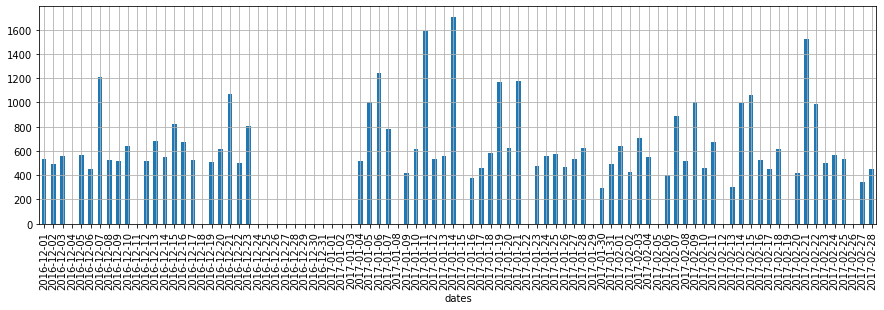

In [41]:
rt.groupby('dates')['revenue'].mean().plot (grid=True, kind='bar', rot=90, figsize=(15,4))

График стал более однородным

------------

Попробуем устранить выбросы

Посмотрим на распределение числа заказов на пользователя

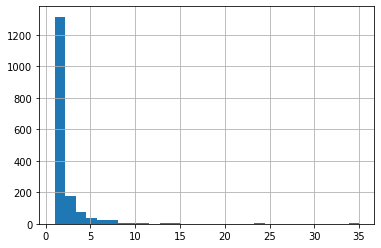

In [42]:
retail.groupby('CustomerID')['purchaseid'].nunique().hist(bins=29)

In [43]:
retail.groupby('CustomerID')['purchaseid'].nunique().describe()

count    1670.000000
mean        1.992814
std         2.348835
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        35.000000
Name: purchaseid, dtype: float64

Посчитаем выборочные перцентили количества заказов на пользователя

In [44]:
print(np.percentile(retail.groupby('CustomerID')['purchaseid'].nunique(), [90, 95, 99]))

[ 4.  5. 11.]


Не более 1% процента клиентов совершели больше 11 заказаов. Выберем 11 заказов в качестве границы для определения аномальных пользователей

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Вот я бы очень хотела, что бы ты начал считать % отреанных данных от первоначального количества. Имхо, 5% - слишком большие потери.</div>

In [45]:
maxorders=11

Проверим какой процент записей потеряем, если применим фильтрацию по maxorders

In [46]:
rt1=retail.groupby('CustomerID')['purchaseid'].nunique().reset_index()
list1=rt1[rt1.purchaseid > maxorders]['CustomerID']

In [47]:
round ( 1- len(retail.query('~ CustomerID.isin(@list1) '))/len(retail) , 2)

0.09

Датасет станет короче на 9%

------------

Посмотрим на распределение стоимостей заказов

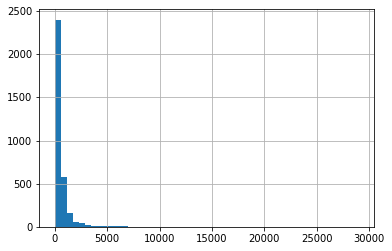

In [48]:
retail['revenue'].hist(bins=50)

In [49]:
retail['revenue'].describe()

count     3328.000000
mean       659.107907
std       1510.571171
min          0.950000
25%        166.733979
50%        350.983679
75%        625.905039
max      29023.985500
Name: revenue, dtype: float64

Определим 90, 95 и 99 перцентили стоимости заказов в выборке

In [50]:
print(np.percentile(retail['revenue'], [90, 95, 99]))

[1189.01700714 2032.01564643 5931.55982003]


Не более 5% заказов дороже 5932 у.е . Выберем 5932 в качестве границы среднего чека для определения аномальных пользователей

In [51]:
maxcheck=5932

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Основные проблемы в данных выявленны, но не все описаны и, имхо, ты теряешь слишком много данных и даже не пишешь, сколько осталось в итоге.</div>

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Теперь этот раздел сделан лучше.</div>

# 3. Анализ программы лояльности

Создадим дополнительную таблицу с числом клиентов по дням и группам. 1 - участник программы лояльности, 0 - не участвовал

In [56]:
visitors=retail.groupby(['date','group' ]).agg({ 'CustomerID' : pd.Series.nunique}).reset_index()
visitors=visitors.rename(columns={'CustomerID':'visitors'})
visitors

,date,group,visitors
0,2016-12-01,0,59.0
1,2016-12-01,1,35.0
2,2016-12-02,0,63.0
3,2016-12-02,1,33.0
4,2016-12-03,0,31.0
...,...,...,...
131,2017-02-25,1,8.0
132,2017-02-27,0,24.0
133,2017-02-27,1,7.0
134,2017-02-28,0,34.0


Создадим массив уникальных пар значений дата и группа

In [57]:
datesGroups = retail[['date','group']].drop_duplicates()
datesGroups

,date,group
0,2016-12-01,1
2,2016-12-01,0
120,2016-12-02,0
122,2016-12-02,1
254,2016-12-03,1
...,...,...
3206,2017-02-25,1
3245,2017-02-27,0
3247,2017-02-27,1
3277,2017-02-28,0


Отфильтруем строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, а группа теста равна группе из datesGroups

In [58]:
ordersAggregated = datesGroups.apply(lambda x: retail[np.logical_and(retail['date'] <= x['date'], retail['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'purchaseid' : pd.Series.nunique,
'CustomerID' : pd.Series.nunique,
'revenue' : 'sum',
'Quantity': 'sum'}), axis=1).sort_values(by=['date','group'])
ordersAggregated

,date,group,purchaseid,CustomerID,revenue,Quantity
2,2016-12-01,0,74,59,4.943765e+04,17043
0,2016-12-01,1,46,35,1.413692e+04,5173
120,2016-12-02,0,147,119,9.400353e+04,35214
122,2016-12-02,1,107,66,3.533003e+04,16120
255,2016-12-03,0,182,148,1.167303e+05,43596
...,...,...,...,...,...,...
3206,2017-02-25,1,1097,551,6.434406e+05,230424
3245,2017-02-27,0,2172,1092,1.524647e+06,544965
3247,2017-02-27,1,1105,553,6.459906e+05,231499
3277,2017-02-28,0,2208,1109,1.542883e+06,550543


<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Кажется, все корректно. Обрати внимание, чеков стабильно больше, чем покупателей. Т.е., некоторые в 1 день делают более 1 покупки.  </div>

In [59]:
ordersByUsersA = retail[retail['group']=='A'].groupby('CustomerID', as_index=False).agg({'purchaseid' : pd.Series.nunique})
ordersByUsersA.columns = ['CustomerID', 'orders']

ordersByUsersB = retail[retail['group']=='B'].groupby('CustomerID', as_index=False).agg({'purchaseid' : pd.Series.nunique})
ordersByUsersB.columns = ['CustomerID', 'orders']

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,date,group,visitors
2,2016-12-01,0,59.0
0,2016-12-01,1,35.0
120,2016-12-02,0,122.0
122,2016-12-02,1,68.0
255,2016-12-03,0,153.0
...,...,...,...
3206,2017-02-25,1,1010.0
3245,2017-02-27,0,1995.0
3247,2017-02-27,1,1017.0
3277,2017-02-28,0,2029.0


In [60]:
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors','quantity']
cummulativeData

,date,group,orders,buyers,revenue,visitors,quantity
0,2016-12-01,0,74,59,4.943765e+04,17043,59.0
1,2016-12-01,1,46,35,1.413692e+04,5173,35.0
2,2016-12-02,0,147,119,9.400353e+04,35214,122.0
3,2016-12-02,1,107,66,3.533003e+04,16120,68.0
4,2016-12-03,0,182,148,1.167303e+05,43596,153.0
...,...,...,...,...,...,...,...
131,2017-02-25,1,1097,551,6.434406e+05,230424,1010.0
132,2017-02-27,0,2172,1092,1.524647e+06,544965,1995.0
133,2017-02-27,1,1105,553,6.459906e+05,231499,1017.0
134,2017-02-28,0,2208,1109,1.542883e+06,550543,2029.0


In [61]:
cummulativeRevenueA = cummulativeData[cummulativeData['group']==0][['date','revenue', 'orders','quantity']]
cummulativeRevenueB = cummulativeData[cummulativeData['group']==1][['date','revenue', 'orders','quantity']]
mergedCummulativeRevenue = cummulativeRevenueA.merge(cummulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

--------

Построим графики кумулятивной выручки по дням и группам A/B

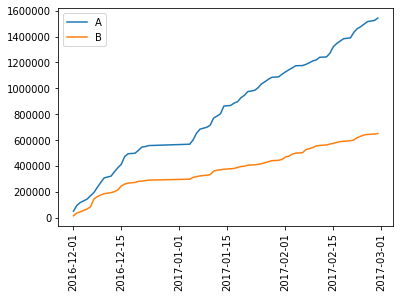

In [62]:
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')
plt.xticks(rotation='vertical')
plt.legend()

На всем промежутке выручка группы В меньше относительно А

Построим график кумулятивного среднего чека по группам

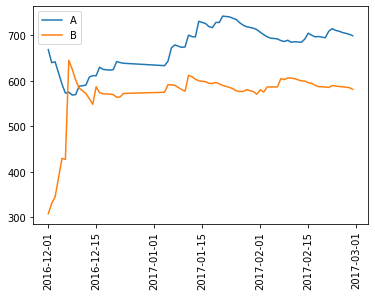

In [63]:
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue']/cummulativeRevenueA['orders'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue']/cummulativeRevenueB['orders'], label='B')
plt.xticks(rotation='vertical')
plt.legend()

Средний чек группы В в начале периода был незначительным, а средний чек группы А превышал 700. Но потом средний чек групп стабилизировалса: А - около 700, В - около 600

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Я бы описала этот график иначе:

* Средний чек группы В сначала был незначительным, а средний чек группы А превышел 700. Но потом довольно быстро средний чек групп стабилизировалса: А - около 600, В  - около 500
</div>

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Отличное описание.</div>

Построим график относительного изменения кумулятивного среднего чека группы B к группе A

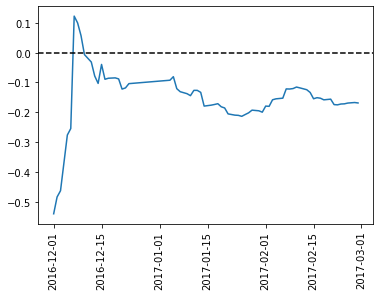

In [64]:
plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB'])/(mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1)
plt.xticks(rotation='vertical')
plt.axhline(y=0, color='black', linestyle='--')

Группа В показывает худший результаты по выручке примерно на 20%

--------

Построим график кумулятивного среднего числа товаров по группам

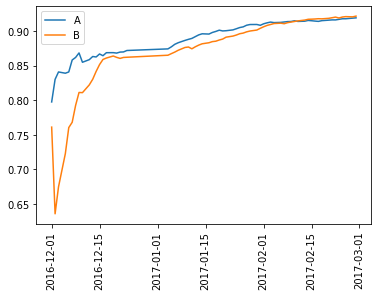

In [65]:
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['quantity']/cummulativeRevenueA['orders'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['quantity']/cummulativeRevenueB['orders'], label='B')
plt.xticks(rotation='vertical')
plt.legend()

В конце периода группа В немного обогнала группу А по числу товаров

Построим график относительного изменения кумулятивного среднего числа товаров группы B к группе A

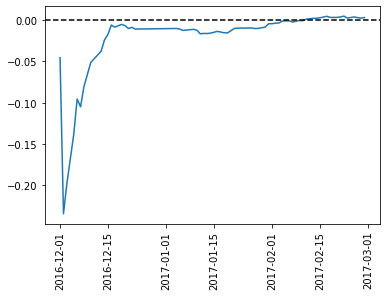

In [66]:
plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['quantityB']/mergedCummulativeRevenue['ordersB'])/(mergedCummulativeRevenue['quantityA']/mergedCummulativeRevenue['ordersA'])-1)
plt.xticks(rotation='vertical')
plt.axhline(y=0, color='black', linestyle='--')

Прирост группы В по числу товаров совсен незначительный около 1%

# 4. Проверка гипотез

Сформулируем гипотезы о среднем чеке обычных клиентов и участников программы лояльности

- Нулевая гипотеза H₀: средний чек групп А и В одинаков
- Альтернативная гипотеза H₁: средний чек групп А и В различается

Сформулируем гипотезы о среднем количестве товаров в заказе обычных клиентов и участников программы лояльности

- Нулевая гипотеза H₀: среднее число товаров в заказе групп А и В одинаково
- Альтернативная гипотеза H₁: среднее число товаров в заказе групп А и В различается

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Формулировки идеальны.</div>

Примем критический уровень значимости alpha=0.05 как среднее значение между наиболее часто используемыми (0.1, 0.05, 0.01)

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Почему уровень альфа именно такой? Я не оспариваю, я хочу понять.</div>

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Теперь твой выбор понятен.</div>

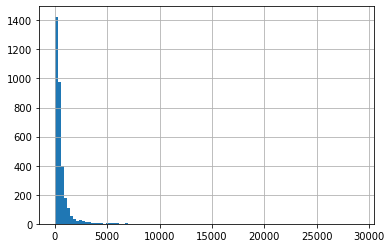

In [67]:
retail['revenue'].hist(bins=100)

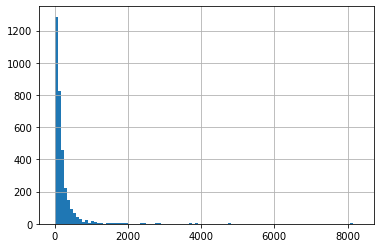

In [68]:
retail['Quantity'].hist(bins=100)

Так как распределения не "нормальны" , используем тест mannwhitneyu

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Отлично.</div>

--------

Посчитаем статистическую значимость различий в среднем чеке заказа по «сырым» данным

значение p-value 

In [69]:
round( st.mannwhitneyu( retail[retail['group']==0]['revenue'] , retail[retail['group']==1]['revenue'] )[1] , 3)

0.0

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Почему mannwhitneyu? Опять же, я не спорю, я хочу понять твою логику рассуждений. И я тебя расстрою - но, кажется, ты изучаешь различия не "среднего чека", а "средней строки в чеке". Хотя выше, кажется, хорошо справился с объединением.</div>

относительное различие  между группами 

In [70]:
round( retail[retail['group']==1]['revenue'].mean() / retail[retail['group']==0]['revenue'].mean()-1 , 3)

-0.169

p-value < alha - между выборками есть значимое отличие не в пользу группы В

--------

Посчитаем статистическую значимость различий в среднем количестве товаров по «очищенным» данным

значение p-value 

In [80]:
round( st.mannwhitneyu( retail[retail['group']==0]['Quantity'] , retail[retail['group']==1]['Quantity'])[1] , 3)

0.0

относительное различие  между группами 

In [72]:
round( retail[retail['group']==1]['Quantity'].mean() / retail[retail['group']==0]['Quantity'].mean()-1 , 3)

-0.164

p-value < alha - между выборками есть значимое отличие не в пользу группы В

--------

Создадим список аномальных пользователей с числом заказов больше 11 и суммой больше 5932 у.е.

In [73]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > maxorders]['CustomerID'], ordersByUsersB[ordersByUsersB['orders'] > maxorders]['CustomerID']], axis = 0)
usersWithExpensiveOrders = retail[retail['revenue'] > maxcheck]['CustomerID']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Тут у нас проблемы, но зато я поняла, как именно ты хочешь использовать ограничение в 95% - и полностью с тобой согласна. Далее не проверяю, но итоговый вывод будет.</div>

--------

Посчитаем статистическую значимость различий в среднем чеке заказа по «очищенным» данным

значение p-value 

In [74]:
round( st.mannwhitneyu(retail[np.logical_and(retail['group']==0, np.logical_not(retail['CustomerID'].isin(abnormalUsers)))]['revenue'],
    retail[np.logical_and(retail['group']==1, np.logical_not(retail['CustomerID'].isin(abnormalUsers)))]['revenue'])[1] , 3)

0.0

относительное различие  между группами 

In [75]:
round( retail[np.logical_and(retail['group']==1, np.logical_not(retail['CustomerID'].isin(abnormalUsers)))]['revenue'].mean()/
    retail[np.logical_and(retail['group']==0, np.logical_not(retail['CustomerID'].isin(abnormalUsers)))]['revenue'].mean() - 1 , 3)

-0.19

p-value < alha - между выборками есть значимое отличие не в пользу группы В

--------

Посчитаем статистическую значимость различий в среднем количестве товаров по «очищенным» данным

значение p-value 

In [76]:
round(st.mannwhitneyu( retail[np.logical_and(retail['group']==0, np.logical_not(retail['CustomerID'].isin(abnormalUsers)))]['Quantity'],
    retail[np.logical_and( retail['group']==1, np.logical_not(retail['CustomerID'].isin(abnormalUsers)))]['Quantity'])[1] , 3)

0.0

относительное различие  между группами 

In [77]:
round( retail[np.logical_and(retail['group']==1,np.logical_not(retail['CustomerID'].isin(abnormalUsers)))]['Quantity'].mean()/
    retail[np.logical_and(retail['group']==0, np.logical_not(retail['CustomerID'].isin(abnormalUsers)))]['Quantity'].mean() - 1 , 3)

-0.077

p-value < alha - между выборками есть значимое отличие не в пользу группы В

# 5. Заключение

- По кумулятивным графикам видно, что группа A опережает B примерно на 15%
- Стат-тесты выявили различие в среднем чеке и количестве товаров в заказе как по «сырым» так и по отфильтраванным данным
- В целом можно сказать, что программа лояльности не оправдывает себя

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> ИТОГО:

* Я не всегда согласна с твоей чисткой данных в первую очередь не столько потому, что как ты их чистишь, а потому - что ты не оставляешь указаний, а сколько процентов данных ты потерял.
* Отрицательные значения в количестве проданных товаров требуют более внимательного изучения и хотя бы объяснения твоих действий - как ты думаешь, как они там оказались? почему ты поступаешь с ними именно так?
* Нет пояснения относительно важных решений - выбора уровня альфа, например.
* Кажется, ты проверяешь не "средний чек", а "среднюю строку чека".

</div>

# 6. Рекомендации

- Можно отказаться от программы лояльности в виду ее неработоспособности
- Либо сделать участие в ней бесплатным, так как в конце периода число товаров в группе В начинает обгонять число товаров группы А и есть вероятность, что бесплатное участие привлечет новых клиентов, которые будут покупать больше. При этом нужно сократить расходы на проведение программы (уменьшить скидки, убрать подарки)

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Все замечания устранены, непонятные моменты нашли сове объяснение. Не хватает рекомендаций.</div>

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 3: </b> Проект принят!</div>

--------

Презентация по ссылке https://docs.google.com/presentation/d/17zSF37epJdy4Rlf-QJDQvOJhLsvhOntiMqTPXtqzHQM/edit?usp=sharing

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Пока не проверяю.</div>

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Приезнтацию принимаю. Вижу там 1 рекомендацию - этого не достаточно.</div>

Список источников, ипользованных при выполнении проекта:

1. Предоработка данных 
https://loginom.ru/blog/missing

https://smysl.io/blog/pandas/

2. Исследовательский анализ данных
http://statistica.ru/theory/opisatelnye-statistiki/

https://habr.com/ru/company/ods/blog/323210/

3. Статистический анализ данных
http://datascientist.one/p-value/

http://www.ipiran.ru/frenkel/hypothesis_testing.pdf

http://www.machinelearning.ru/wiki/index.php?title=%D0%A3%D1%80%D0%BE%D0%B2%D0%B5%D0%BD%D1%8C_%D0%B7%D0%BD%D0%B0%D1%87%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8

http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%A3%D0%B8%D0%BB%D0%BA%D0%BE%D0%BA%D1%81%D0%BE%D0%BD%D0%B0-%D0%9C%D0%B0%D0%BD%D0%BD%D0%B0-%D0%A3%D0%B8%D1%82%D0%BD%D0%B8

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида: </b> Серьезно?! Предполагается, что ты все модули Практикума использовал. А еще предполагается, что ты ищучал и другие источники информации - вот ими и нужно поделиться.</div>

<div style="border:solid green 4px; padding: 20px"> <b>Комментарий тимлида 2: </b> Уже лучше! </div>